Imports

In [32]:
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import random

Base

In [100]:
df = pd.read_excel("normalizacao/normalizado-Amaro.xlsx",header = None)
len(df)

611

In [35]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,Normal,797766418.0,7.976836e+08,7.976132e+08,7.976932e+08,7.978051e+08,7.977534e+08,7.975633e+08,7.980001e+08,7.985450e+08,...,5.927387e+08,5.925812e+08,5.925742e+08,5.926284e+08,5.926800e+08,5.924132e+08,5.924986e+08,5.927184e+08,5.927748e+08,592758179.0
1,Normal,592893188.0,5.929576e+08,5.930038e+08,5.930056e+08,5.929661e+08,5.928822e+08,5.928130e+08,5.928260e+08,5.928952e+08,...,7.945067e+08,7.944689e+08,7.945062e+08,7.945400e+08,7.945050e+08,7.944806e+08,7.945024e+08,7.944988e+08,7.944228e+08,794261597.0
2,Normal,794196960.0,7.942114e+08,7.942750e+08,7.942332e+08,7.941412e+08,7.941456e+08,7.941471e+08,7.945786e+08,7.952045e+08,...,5.899185e+08,5.897557e+08,5.897092e+08,5.897825e+08,5.898335e+08,5.897254e+08,5.896366e+08,5.896476e+08,5.898321e+08,590020081.0
3,Normal,590020813.0,5.899802e+08,5.899391e+08,5.899551e+08,5.899282e+08,5.899542e+08,5.899806e+08,5.900231e+08,5.900554e+08,...,7.983703e+08,7.984350e+08,7.984996e+08,7.985776e+08,7.986325e+08,7.985593e+08,7.984473e+08,7.983986e+08,7.983111e+08,798115662.0
4,Normal,798007568.0,7.979743e+08,7.978910e+08,7.978479e+08,7.977852e+08,7.976765e+08,7.977107e+08,7.977559e+08,7.977479e+08,...,5.907331e+08,5.906532e+08,5.905842e+08,5.906232e+08,5.906981e+08,5.906141e+08,5.905779e+08,5.905933e+08,5.906006e+08,590630615.0


In [36]:
df_x = df.drop([0],axis=1)

In [37]:
print(df[0].unique())

['Normal' 'Duplo' 'Ritmo']


In [38]:
# Classificando Normal = 0 e outros comportamentos como = 1
df['fadiga'] = [0 if x == 'Normal' else 1 for x in df[0]]
df['classes_completa'] = [0 if x == 'Normal' else 1 if x == 'Duplo' else 2 for x in df[0]]
df_y =  df['fadiga']
df_y_real = df['classes_completa']

In [39]:
count = 0
for i in df_y:
    if i == 0:
        count += 1
print(f'% de Normal: {count/len(df_y) * 100}')

% de Normal: 88.54337152209493


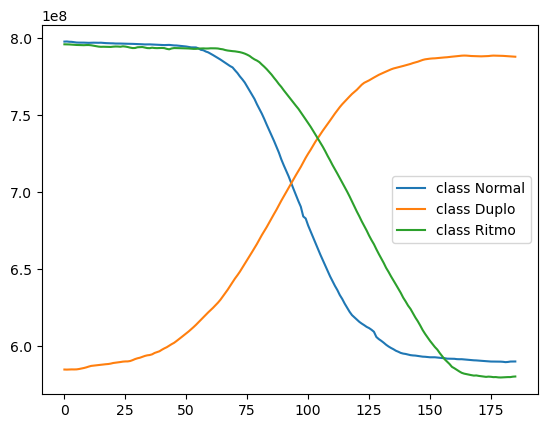

In [40]:
#Mostrando exemplos de cada classe
classes = np.unique(df_y_real, axis=0)
idx = np.random.default_rng(seed=42).permutation(len(df_x))
nova_df_x = df_x.values[idx]
nova_df_y = df_y_real.values[idx]
plt.figure()
for c in classes:
    c_x_train = nova_df_x[nova_df_y == c]
    if c == 0:
        text = 'Normal'
    if c == 1:
        text = 'Duplo'
    if c == 2:
        text = 'Ritmo'
    plt.plot(c_x_train[0], label="class " + str(text))
plt.legend(loc="best")
plt.show()
plt.close()

Treino e Teste

In [42]:
#Randomizar a ordem
idx = np.random.permutation(len(nova_df_x))
nova_df_x = df_x.values[idx]
nova_df_y = df_y.values[idx]

#Separar em Treino (70%), Validação (20%) e Teste (10%)
n = len(nova_df_x)
train_df_x = nova_df_x[0:int(n*0.7)]
val_df_x = nova_df_x[int(n*0.7):int(n*0.9)]
test_df_x = nova_df_x[int(n*0.9):]

train_df_y = nova_df_y[0:int(n*0.7)]
val_df_y = nova_df_y[int(n*0.7):int(n*0.9)]
test_df_y = nova_df_y[int(n*0.9):]

train_x,train_y = train_df_x,train_df_y
val_x,val_y = val_df_x,val_df_y
test_x,test_y = test_df_x,test_df_y
num_features = test_df_x.shape[1]

Normalização

In [44]:
train_mean = train_x.mean()
train_std = train_x.std()

train_x = (train_x - train_mean) / train_std
val_x = (val_x - train_mean) / train_std
test_x = (test_x - train_mean) / train_std

In [45]:
num_classes = len(np.unique(train_y))

In [46]:
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
val_x = val_x.reshape((val_x.shape[0], val_x.shape[1], 1))
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], 1))

In [47]:
train_x.shape

(427, 186, 1)

Modelo

In [49]:
def make_model_lstm(input_shape):
    input_layer = tf.keras.layers.Input(input_shape)
    lstm1 = tf.keras.layers.LSTM(16,return_sequences=True)(input_layer)
    lstm2 = tf.keras.layers.LSTM(8)(lstm1)
    output_layer = tf.keras.layers.Dense(num_classes)(lstm2)
    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [50]:
def make_model_rnn(input_shape):
    input_layer = tf.keras.layers.Input(input_shape)
    rnn1 = tf.keras.layers.SimpleRNN(16,return_sequences=True)(input_layer)
    rnn2 = tf.keras.layers.SimpleRNN(8)(rnn1)
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(rnn2)
    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [51]:
def make_model_cnn(input_shape):
    input_layer = tf.keras.layers.Input(input_shape)
    cn2 = tf.keras.layers.Conv1D(32,kernel_size=3,padding="same")(input_layer)
    max = tf.keras.layers.MaxPooling1D()(cn2)
    flat = tf.keras.layers.Flatten()(max)
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(flat)
    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [52]:
def make_model_fcnn(input_shape):
    input_layer = tf.keras.layers.Input(input_shape)

    conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)

    conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)

    conv3 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)

    gap = tf.keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")(gap)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [53]:
model_lstm = make_model_lstm(input_shape= train_x.shape[1:])

model_lstm.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 186, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 186, 16)             │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,970 (7.70 KB)

 Trainable params: 1,970 (7.70 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
model_rnn = make_model_rnn(input_shape= train_x.shape[1:])

model_rnn.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 186, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 186, 16)             │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 8)                   │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 506 (1.98 KB)

 Trainable params: 506 (1.98 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
model_cnn = make_model_cnn(input_shape= train_x.shape[1:])

model_cnn.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 186, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 186, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 93, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2976)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           5,954 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,082 (23.76 KB)

 Trainable params: 6,082 (23.76 KB)

 Non-trainable params: 0 (0.00 B)

Parametros utilizados para rodar as Épocas

In [57]:
epochs = 50
batch_size = 32

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1),
]

LSTM

In [59]:
model_lstm.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[
        "sparse_categorical_accuracy"
    ]
)
history = model_lstm.fit(
    train_x,
    train_y,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - loss: 3.0889 - sparse_categorical_accuracy: 0.5950 - val_loss: 0.4911 - val_sparse_categorical_accuracy: 0.8605 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.4338 - sparse_categorical_accuracy: 0.8797 - val_loss: 0.4193 - val_sparse_categorical_accuracy: 0.8605 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.4458 - sparse_categorical_accuracy: 0.8851 - val_loss: 0.4191 - val_sparse_categorical_accuracy: 0.8605 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3906 - sparse_categorical_accuracy: 0.8816 - val_loss: 0.4191 - val_sparse_categorical_accuracy: 0.8605 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.4538 - sparse_categorical_accuracy: 0.8979 - val_loss: 0.4191 - val_sparse_categorical_accuracy: 0.8605 - learning_rate: 0.0010
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - l

In [60]:
model_lstm = tf.keras.models.load_model("best_model.keras")

test_loss, test_acc = model_lstm.evaluate(test_x, test_y)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2145 - sparse_categorical_accuracy: 0.9466
Test accuracy 0.9354838728904724
Test loss 0.24595560133457184


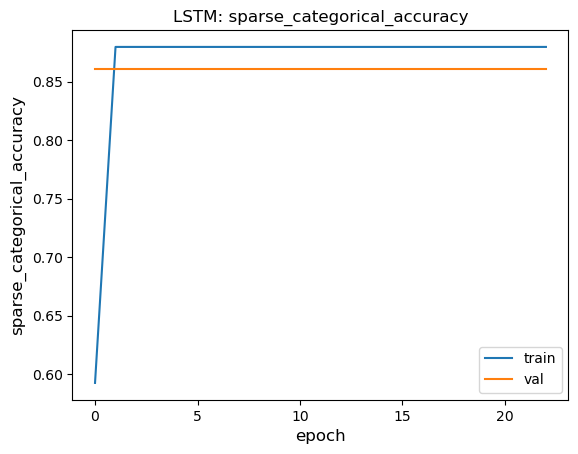

In [61]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("LSTM: " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

RNN

In [63]:
model_rnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model_rnn.fit(
    train_x,
    train_y,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.7052 - sparse_categorical_accuracy: 0.6004 - val_loss: 0.6661 - val_sparse_categorical_accuracy: 0.5349 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.6169 - sparse_categorical_accuracy: 0.6359 - val_loss: 0.5897 - val_sparse_categorical_accuracy: 0.8605 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.5641 - sparse_categorical_accuracy: 0.8727 - val_loss: 0.5218 - val_sparse_categorical_accuracy: 0.8605 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.4748 - sparse_categorical_accuracy: 0.8742 - val_loss: 0.4325 - val_sparse_categorical_accuracy: 0.8605 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.3805 - sparse_categorical_accuracy: 0.8974 - val_loss: 0.3766 - val_sparse_categorical_accuracy: 0.8605 - learning_rate: 0.0010
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - lo

In [64]:
model_rnn = tf.keras.models.load_model("best_model.keras")

test_loss, test_acc = model_rnn.evaluate(test_x, test_y)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1570 - sparse_categorical_accuracy: 0.9466 
Test accuracy 0.9354838728904724
Test loss 0.181435689330101


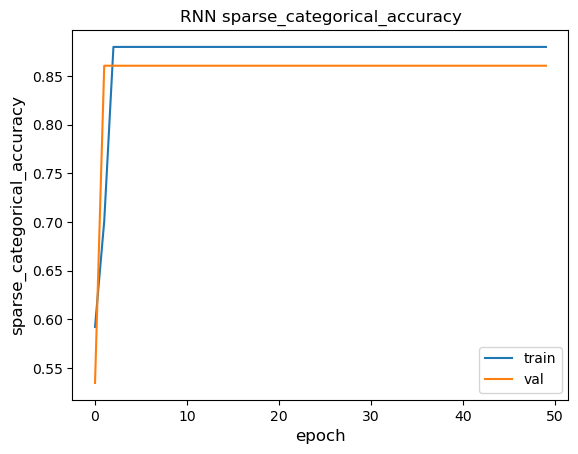

In [65]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("RNN " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

CNN

In [67]:
model_cnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model_cnn.fit(
    train_x,
    train_y,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.7390 - sparse_categorical_accuracy: 0.5303 - val_loss: 0.6379 - val_sparse_categorical_accuracy: 0.7791 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5809 - sparse_categorical_accuracy: 0.7502 - val_loss: 0.5105 - val_sparse_categorical_accuracy: 0.8256 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4255 - sparse_categorical_accuracy: 0.9176 - val_loss: 0.3858 - val_sparse_categorical_accuracy: 0.8605 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3409 - sparse_categorical_accuracy: 0.8830 - val_loss: 0.3421 - val_sparse_categorical_accuracy: 0.8605 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3227 - sparse_categorical_accuracy: 0.8811 - val_loss: 0.3386 - val_sparse_categorical_accuracy: 0.8605 - learning_rate: 0.0010
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0

In [68]:
model_cnn = tf.keras.models.load_model("best_model.keras")

test_loss, test_acc = model_cnn.evaluate(test_x, test_y)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1526 - sparse_categorical_accuracy: 0.9466  
Test accuracy 0.9354838728904724
Test loss 0.17916084825992584


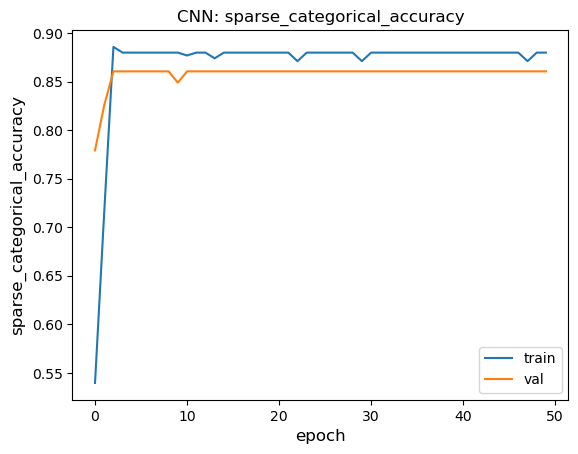

In [69]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("CNN: " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()